# OPTUNA - subject 69

![Optuna-logo](images/optuna-logo.png)


- [Link to the article (arxiv)](https://arxiv.org/abs/1907.10902)
- [Link to the documentation](https://optuna.readthedocs.io/en/latest/index.html#)


Optuna is an open-source framework that aims to make tuning hyperparameters better.

Very broadly speaking, it wraps around an optimization code, and explores the parameters space looking for the parameters set that yields the best solution.

We will first go over a simple example, using NIST dataset, that introduces Optuna and how it can be used.

Then, we will go a bit deeper on the possibilities offered by Optuna. 


In [1]:
!pip install optuna;

In [35]:
# IMPORTS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import partial
import warnings
warnings.filterwarnings('ignore')

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.utils import shuffle
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
from sklearn import datasets, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

# visualisation
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice 

SEED = 42
np.random.seed(SEED);

In [3]:
def plot_digits(images, count=4):
    ncols = 4
    nrows = (count + ncols - 1)//ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3*nrows))
    axes = axes.flatten()
    for ax, image in zip(axes, images):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

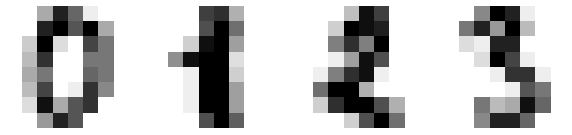

In [4]:
digits = datasets.load_digits() # data images, target, target_names

split_index = 1000
x = digits.data
y = digits.target
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size=0.5, random_state=0)

plot_digits(digits.images)

# Introductory example

As an introductory example, we use a Decision Tree Classifier to predict the digit from the image.

In [5]:
digits_dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10)
digits_dt.fit(x_train, y_train)
prediction = digits_dt.predict(x_test)
print("Generalization error:", np.sum(np.not_equal(prediction, y_test))/len(y_test) )
print("Generalization score:", digits_dt.score(x_test, y_test))

Generalization error: 0.2135706340378198
Generalization score: 0.7864293659621802


Suppose that we want find the best hyperparameters to maximize the score. The most naive way to do it is by grid-search.

In [6]:
best_score = 0
best_params = None
nb_trials = 0
for depth in [10, 20, 30]:
    for min_samples_leaf in [3, 5, 10, 20]:
        digits_dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth, min_samples_leaf=min_samples_leaf)
        digits_dt.fit(x_train, y_train)
        prediction = digits_dt.predict(x_test)
        score = digits_dt.score(x_test, y_test)
        if(score > best_score):
            best_score = score
            best_params = (depth, min_samples_leaf)
        nb_trials += 1

print('Best score={:0.2f} obtained for parameters={} after {} trials.'.format(score, best_params, nb_trials))

Best score=0.75 obtained for parameters=(20, 3) after 12 trials.


As you see, we have to statically define the parameters to try and somewhat trial-and-error our way to the best solution, even with grid search. Of course, the Design of Experiment (DoE) can be improved quite easily, using latin hypercube for example. 

However, Optuna, an optimization framework, offers the possibility to ease this process in a very way :
- We define an objective function that calls, for the parameters we want to optimize on, the `suggest_API` and outputs a objective value (to minimize in this case).
- Then, we define a study. 
- Finally we call the `optimize` function. By default it seeks to minimize the score.

After the trial is over, finding the best set of parameters is done by calling member fields of the *study* object.

In [7]:
def objective_(trial, x, y):
    sug_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    sug_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)

    classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=sug_max_depth, min_samples_leaf=sug_min_samples_leaf)
    x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(x, y, train_size=0.5, random_state=0)
    classifier_obj.fit(x_train, y_train)
    score = classifier_obj.score(x_valid, y_valid)
    return score # we want to maximize score

n_trials = 10 # limiting the study to 10 trials
objective = partial(objective_, x=x_train, y=y_train)
study = optuna.create_study(direction="maximize")  # Create a new study.
study.optimize(objective, n_trials=n_trials)  # Invoke optimization of the objective function
print('Best score={:0.2f} obtained for parameters={} after {} trials.'.format(study.best_value, study.best_params, n_trials))

Best score=0.91 obtained for parameters={'rf_max_depth': 17, 'min_samples_leaf': 8} after 10 trials.


So with the same number of trials, we found a better solution than what we could do with simple grid-search. Optuna also makes it easier to understand what goes on during the study with plots as seen afterwards. For more information, you can check [here](https://optuna.readthedocs.io/en/latest/tutorial/10_key_features/005_visualization.html#visualization). 

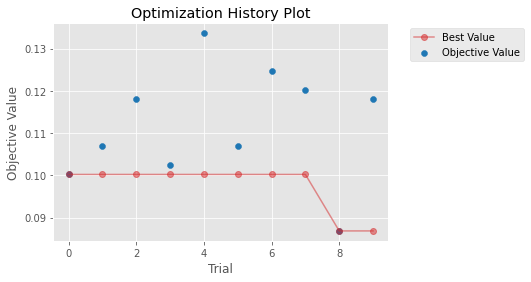

In [8]:
plot_optimization_history(study);
# plot_parallel_coordinate(study);
# plot_param_importances(study);

## Optuna

## General principles
The principle behind Optuna is rather straight forward. One starts by defining an objective function that should take as input a `trial` object (more on that later) and outputs a quantity to be optimized. This objective function should make calls to a `suggest_API` that indeed suggests parameters based on previous steps and user-defined constraints. 

Then, one simply creates a `study` object and call the optimisation function with parameter the objective function. A study is composed of several trials where a trial is simply a optimisation process with a given set of parameters. The study is one process of looking for the best parameter set respecting the constraint given by the user under a certain time limit or number of trials limit for example.


### Full API diagram 
In the following sections, we will go over most of the API functions.
![optuna-api](images/architecture_optuna.png)

Succintly, for those that we will see :
- suggest() : suggest a value for a given parameter
- should_prune() : True if trial should be terminated before its end (because it is unpromising) !
- report() : report an objective function value for a given step.

### Authors goal
It is interesting because one of the most painful process of developping new models is actually finding the right set of parameters. 

The authors present had three main goals when creating the Optuna framework :
1. Dynamically create the parameter research space (which they call *define-by-run* API, in opposition to the *define-and-run* which forces you to explicitely define your research space before running the experiment);
2. Implement efficient research and pruning algorithms;
3. Easy use of the framework, from the light weighted application to the distributed one.

## Space Search algorithm
It is now time to discuss a bit more what goes on in Optuna with the Suggest_API and more precisely the space search algorithm.

There are two methods used to sample parameters, they can either be sampled independtly or in correlation to one another. Optuna being a define-by-run API, there is no preliminary knowledge of the correlation between two parameters. 

Thus, Optuna, by default, starts with independent sampling, and after "enough" trials, can draw correlations between parameters that allow it to sample with correlation. The first iterations are effected with the TPE algorithm, while subsequent ones can use CMA-ES algorithms (if valid, that is no categorical parameters).

At the time of this writing, Optuna features a lot of samplers which can be found [here](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html). In the following, we will only describe *TPE* which is not that known, mostly because it is the base one for Optuna and that it works well despite not having hyperparameters correlation.

### Tree-structured Parzen Estimator (TPE)

TPE works in the following way.

We split the different sets of parameters into two groups. One contains the sets that yields the best results. The other group contains all other sets.

Suppose that we have two functions, $l$ and $g$, that applied on a set of parameters $x$ returns the likelihood probability $l(x)$ that $x$ leads to a "best" result or $g(x)$ that it does not.

With those functions, we can then rank sets of parameters by this quantity called Expected Improvement $EI(x) = \frac{l(x)}{g(x)}$. The $x$ maximising this quantity is therefore choosen for the next trial.


TPE needs to warning up : the first iterations and parameters set are generally sampled randomly (uniformely). Then,the best sets of parameters are selected to be in the first group and function $l$ and $g$ can be computed. The fraction used to create group 1 is a parameter of the TPE algorithm.

Last, but not least, it is time to explain why one would call TPE lthe Tree-Structured Parzen Estimator :
1. Parzen Estimator : the TPE algorithm uses parzen-window density estimators, which means that a gaussian distribution is used for every parameter with mean the value of the parameter. The distributions are then summed up over all the samples and normalized in order to have a probability density function. Hence the name in TPE.
2. The "tree-structure" naming is because the parameter space can be seen as a tree. Each node is a choice to make has consequences on future choice. This is easier to understand with the following examples where you will see that we first choose what model to apply, and then sample its specific parameters.

TPE main issue is that it does not model any correlation between parameters. The next algorithms deal with this. 

For more information, please refer to
- [this article, harder](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)
- [this documentation, easier](http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#tree-structured-parzen-estimators-tpe)

Note : Optuna also implements a mutli-objective TPE sampler called [MOTPE](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.MOTPESampler.html).

### Covariance Matrix Adaptation Evolutionary Strategy (CMA-ES)
This is the well-known evolutionnary algorithms for **continuous** cases, which strength lies in that it adapts the distribution to generate the next individuals (sets of parameters) considering the current population. Note that it can not be used with categorical settings ! 



## What can we really do with Optuna ?

Optuna can suggest three types of features ([source](https://optuna.readthedocs.io/en/latest/tutorial/10_key_features/002_configurations.html#sphx-glr-tutorial-10-key-features-002-configurations-py)):
- categorical : `trial.suggest_categorical(str:name, choices:Sequence[Union[None, bool, int, float, str]])`
- integers : `trial.suggest_int(name:str, low:int, high:int, step=1, log=False)`
- floats : `trial.suggest_float(name:str, low:float, high:float, step=None, log=False)`


The parameters they take in inputs are mostly quite clear :
- *log* : if `True`, the value is sampled uniformely from the range in the log domain.
- *choices : can be a sequence of anything, e.g. ['Random Forest Classifier', 'KNeightbors'] or [None, np.pi, 'SVM', 0, True].
- high is **included**



### Exercice 1
Next is an exercice. Propose an objective function `objective_ex1` that optimizes, for the NIST dataset, on :
- Random Forest Classifier on the maximum depth and minimum samples in leaf
- Gaussian Process Classifier on kernel (try for example the Radial Basis `RBF` with different value for the length scale)
- Support Vector Classifier on the Kernel coefficient and Regularization parameter

Run the study for 10 seconds (using the `timeout` parameter in the `study.optimize` function).

Optuna is modular, try to respect this principle too !

In [9]:
# %load solutions/ex1.py

## Pruning
So we can get quickly a good classifier on a simple task and with only several lines of codes. But, that is not all that Optuna can do.

Indeed, Optuna implements pruning strategies (also called automated early-stopping) to cut short unpromising specific trials. When done smartly, this allows to cut entire region of the parameter search space. It is to be noted that it can only be used when one can compute intermediate results.


### Asynchronous Successive Halving algorithm
The original algorithm, described in the article, is the Asynchronous Successive Halving algorithm (ASHA). In ASHA, several workers compute solutions and can asynchronously execute aggressive early stopping using the current rank of their solution (asynchronicity is very useful for distributed environnement, processes do not have to wait for one another).

For each trial, the pruning algorithm first computes the *rung* of the trial, which is the number of times the trial has survived the trial process. Then, if the trial is in the top $1/\eta$ of all previous trials of same rung, where $\eta$ is called the reduction factor, it is allowed to enter the next round, otherwise it is pruned. In the classical version, if the number of trials at a given rung is less that $1/\eta$, the best one is selected for the next round. However, this means that checkpoints of every configuration have to be made. Optuna, for efficiency reasons, implements a slightly different version of ASHA where no repechage is allowed (no checkpoints thus).

As said previously, pruning makes sense when we have intermediary results. We will now see an example where pruning makes sense. 

Note : Optuna has multiple pruning algorithms implemented. More information [here](https://optuna.readthedocs.io/en/latest/tutorial/10_key_features/003_efficient_optimization_algorithms.html#pruning-algorithms).




# Adding pruning : MNIST and CNN
Let's try on MNIST. MNIST is the same as NIST but with more pictures and better resolution since we are up from 8x8 to 28x28. In our case, the training set, originally 60K is limited to 10K, because otherwise it is taking too long.

For the next part, it is (much) better to use a GPU. If you don't have one available, you can use NIST dataset, but results will be harder to analyze. Also, you should modify the research space for the convolution neural network if you prefer using the NIST dataset.

In [12]:
import torch
# simple Dataset for NIST
class ImageClassificationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data: np.ndarray,
        labels: np.ndarray
    ):
        self.data = data
        self.targets = labels

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index: int):
        x = self.data[index]
        y = self.targets[index]
        x = torch.tensor(x)
        y = torch.tensor(y)
        return x, y

In [13]:
import torchvision
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = "MNIST" # "MNIST"

if(dataset=="NIST"):
  x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(digits.images, y, train_size=0.5, random_state=0)

  train_data = ImageClassificationDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float())
  test_data = ImageClassificationDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float())

elif(dataset == 'MNIST'):
  train_data = torchvision.datasets.MNIST(
      root = 'data',
      train = True,                         
      transform = torchvision.transforms.ToTensor(), 
      download = True,            
  );
  test_data = torchvision.datasets.MNIST(
      root = 'data', 
      train = False,
      transform = torchvision.transforms.ToTensor()
  );
  # Limiting the size of the training set because it takes too much time otherwise !
  limit_train = 10000
  limit_test = 1000

  # subset training set
  index_sub = np.random.choice(np.arange(len(train_data)), limit_train, replace=False)

  #replacing attribute
  train_data.data = train_data.data[index_sub]
  train_data.targets = train_data.targets[index_sub]

  # subset testing set
  index_sub = np.random.choice(np.arange(len(test_data)), limit_test, replace=False)

  #replacing attribute
  test_data.data = test_data.data[index_sub]
  test_data.targets = test_data.targets[index_sub]

# train_data, valid_data = torch.utils.data.random_split(train_data_full, [limit_train, len(train_data_full) - limit_train])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



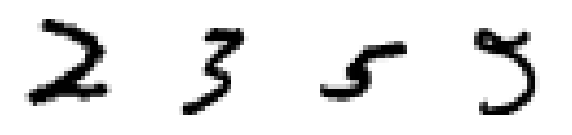

In [14]:
plot_digits(train_data.data[:4].numpy())

In [15]:
x_train_, y_train_ = train_data.data.numpy().reshape(len(train_data), -1), train_data.targets.numpy()

### Exercice 2 :

Using `x_train_` and `y_train_`, try again the previous example on the partial version of MNIST. You can choose a timeout of 60 seconds. 

> Note : you may want to interrupt if it's taking too long ...

In [16]:
# %load solutions/ex2.py

   0%|          | 00:00/00:10

Best score=0.91420 obtained for parameters={'classifier': 'RandomForestClassifier', 'max_depth': 22, 'min_samples_leaf': 10} after 10 trials.


So we see that we don't succeed anymore in reaching top score. Let's now try with deep learning and convolutional neural networks. 

Next cell defines useful classes that we are going to use in the next exercice.

In [17]:
# get out shape of the image when using conv2D
def get_h_out(h_in, kernel_size, padding=0, dilation=1, stride=1):
- [Link to the article (arxiv)](https://arxiv.org/abs/1907.10902)
- [Link to the documentation](https://optuna.readthedocs.io/en/latest/index.html#)

        assert((len(c_in_list) == len(c_out_list)) and (len(kernel_size_list) == len(c_out_list)))
        for c_in, c_out, k in zip(c_in_list, c_out_list, kernel_size_list):
            conv_list.append(torch.nn.Conv2d(c_in, c_out, k))
        self.conv = torch.nn.Sequential(*conv_list)
        self.fc1 = torch.nn.Linear(output_size, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv(x)
        x = torch.nn.functional.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        output = torch.nn.functional.sigmoid(x)
        return output


# This class mirrors Sklearn MLP Classifier class and mainly proposes three functions :
# 1. train(train_loader, epochs)
# 2. train_one(train_loader)
# 3. score(valid_loader)
# The loader should be a Pytorch Dataloader object.
# You can initialize it like this :
# torch_classifier = TorchClassifier(model, lr)
# with model created from SmallConvNet
class TorchClassifier:
    def __init__(self, model, lr, verbose=True) -> None:
        self.model = model
        self.lr = lr
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.optimiser = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        self.verbose = verbose

    def train(self, train_loader, epochs):
        train_loss_list = []
        for epoch in tqdm(range(epochs), disable=not self.verbose):
            train_loss = self.train_one_epoch(train_loader)
            train_loss_list.append(train_loss)
        return train_loss_list

    def train_one_epoch(self, train_loader):
        loss_list = []
        for x, y in train_loader:
            x = x.to(self.device)
            y = y.to(self.device)
            pred = self.model(x)
            self.optimiser.zero_grad()
            loss = self.loss_function(pred, y)
            loss.backward()
            self.optimiser.step()
            loss_list.append(loss.detach().cpu().numpy())
        return np.mean(loss_list)

    def predict(self, test_loader, return_true=False):
        self.model.eval()
        pred_list = []
        true_list = []
        with torch.no_grad():
            for x, y in test_loader:

                x = x.to(self.device)
                y = y.to(self.device)
                pred = self.model(x)
                pred_list.append(pred)
                true_list.append(y)
        self.model.train()
        if(return_true):
            return torch.concatenate(true_list, axis=0), torch.concatenate(pred_list, axis=0)
        return torch.concatenate(pred_list, axis=0)
    
    def score(self, test_loader):
        true, pred = self.predict(test_loader, return_true=True)
        accuracy = get_accuracy(true.cpu().numpy(), pred.cpu().numpy())
        return accuracy

def get_accuracy(y_true, y_prob):
    assert (y_true.ndim == 1 and y_true.shape[0] == y_prob.shape[0])
    y_prob = np.argmax(y_prob, axis=-1)
    return sklearn.metrics.accuracy_score(y_true, y_prob)

### Exercice 3 :
With that, we can write an objective function, called `cnn_naive_objective`, that handles the parameter search for SmallConvNet playing on the number of layers and learning rate. If you are in a good day, try also suggesting the number of out channels and the kernel size.

> `get_w_out` and `get_h_out` may be useful !

Choose a timeout of 3 mins and while it is running, try the next exercice !

In [18]:
# %load solutions/ex3.py

### Exercice 4

Add pruning now to your previous code now !

You can take inspiration from [here](https://optuna.readthedocs.io/en/latest/tutorial/10_key_features/003_efficient_optimization_algorithms.html#pruning-algorithms).

In [20]:
# %load solutions/ex4.py

In [22]:
print(f'With pruning, we explored {len(study_pruning.trials)} trials in {timeout} sec, whereas without, we only explored {len(study_no_pruning.trials)}.')

With pruning, we explored 16 trials in 180 sec, whereas without, we explored 10.


So we see how pruning can effectively increase the speed of convergence. With only a few minutes of running, we did not necessarily get to a better solution (maybe you did, lucky you !). However, on real cases, exploring more of the hyperparameters space will yield to better solution faster, given enough exploration time !

## Comparison

In the next cells, we will compare TPE with a random sampler, and also pruning with no pruning. TPE and Random Sampling are the only samplers (apart from brute force...) that are efficiently programmed for pruning and categorical values, which is why we don't try CMA-ES or NSGA-II for example.

In [23]:
study_1= optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.NopPruner(),
    study_name='random',
    sampler= optuna.samplers.RandomSampler()
)

study_2 = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name='random_pruner',
    sampler= optuna.samplers.RandomSampler()
)

study_3 = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.NopPruner(),
    study_name='tpe',
    sampler= optuna.samplers.TPESampler()
)

study_4 = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name='tpe_pruner',
    sampler= optuna.samplers.TPESampler()
)

In [24]:
timeout = 180
objective = partial(cnn_naive_objective, train_data=train_data, valid_data=test_data, pruning=True)
study_1.optimize(objective, timeout=timeout, show_progress_bar=True) 
study_2.optimize(objective, timeout=timeout, show_progress_bar=True) 
study_3.optimize(objective, timeout=timeout, show_progress_bar=True) 
study_4.optimize(objective, timeout=timeout, show_progress_bar=True)

   0%|          | 00:00/03:00

   0%|          | 00:00/03:00

   0%|          | 00:00/03:00

   0%|          | 00:00/03:00

In [27]:
def get_best_values_as_a_function_of_time(df): 
  best_value = 0
  times = np.zeros(df.shape[0])
  best_values = np.zeros(df.shape[0])
  for i, (row_name, row) in enumerate(df.iterrows()):
    if(row['value'] > best_value):
      best_value = row['value']
    times[i] = row['value']
    best_values[i] = best_value
  return np.cumsum(times), best_values

df1 = study_1.trials_dataframe()
df2 = study_2.trials_dataframe()
df3 = study_3.trials_dataframe()
df4 = study_4.trials_dataframe()
t1, v1 = get_best_values_as_a_function_of_time(df1)
t2, v2 = get_best_values_as_a_function_of_time(df2)
t3, v3 = get_best_values_as_a_function_of_time(df3)
t4, v4 = get_best_values_as_a_function_of_time(df4)

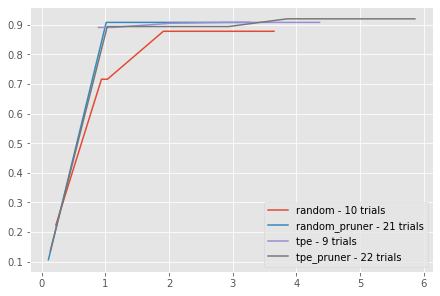

In [32]:
fig, ax = plt.subplots(constrained_layout=True)
sns.lineplot(x=t1, y=v1, label=f'{study_1.study_name} - {len(study_1.trials)} trials', ax=ax)
sns.lineplot(x=t2, y=v2, label=f'{study_2.study_name} - {len(study_2.trials)} trials', ax=ax)
sns.lineplot(x=t3, y=v3, label=f'{study_3.study_name} - {len(study_3.trials)} trials', ax=ax)
sns.lineplot(x=t4, y=v4, label=f'{study_4.study_name} - {len(study_4.trials)} trials', ax=ax)

# Bonus
## Deploying
Deploying with fixed parameters is possible using the `FixedTrial` class. It has almost the same functionnalities as the `Trial` class, however it does not modify the parameters. Once a best set has been found, one can create a FixedTrial and use it in the objective function directly. 

It is common to save the "best model" states in neural networks (to not have to retrain everything). One would need to do that manually in the objective function ! 

## Dashboard
In addition to a several plotting functions, Optuna also features a dashboard, that allow one to follow a study and analyse it in real time. More info [here](https://optuna.readthedocs.io/en/latest/tutorial/10_key_features/005_visualization.html#sphx-glr-tutorial-10-key-features-005-visualization-py) and in the associated [github](https://github.com/optuna/optuna-dashboard).

Unfortunately, the dashboard is not available for use in Google Collab.

## User-defined samplers and pruners
It is possibly to manually define a sampler (see [here](https://optuna.readthedocs.io/en/latest/tutorial/20_recipes/005_user_defined_sampler.html#sphx-glr-tutorial-20-recipes-005-user-defined-sampler-py)) or pruner (see [here](https://optuna.readthedocs.io/en/latest/tutorial/20_recipes/006_user_defined_pruner.html#sphx-glr-tutorial-20-recipes-006-user-defined-pruner-py)).

The sampler should derive from `BaseSampler` and contain three member methods:
- `infer_relative_search_space(study, trial) -> A dictionary containing the parameter names and parameter’s distributions.`
- `sample_relative(study, trial, search_space) -> A dictionary containing the parameter names and the values.`
- `sample_independent(study, trial, param_name, param_distribution) -> A parameter value.`

As for the pruner should contain a member method with signature: `prune(self, study: "optuna.study.Study", trial: "optuna.trial.FrozenTrial") -> bool` (it returns `True` if trial should be pruned) and should derive from `BasePruner`. 

## A note on heavier architecture
All architectures seen here a simpler ones. However, Optuna also addresses much heavier architecture running, possibly running on a cluster. In this case, you can redefine the way storage occurs to fit your need. 

## Other frameworks

Other frameworks exist, none other was tested here, but the article provides a comparison of some of them :
![frameworks](images/other_frameworks.png)

However, since the article was published (2019) new one have made their apparition !